<a href="https://colab.research.google.com/github/mebene79/CoolStuff/blob/main/XgboostProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We explore diffrent ways to handle missing data in the Mushroom Data Set
https://archive.ics.uci.edu/ml/datasets/mushroom

In this Dataset the features and target are all categorical and one feature has misssing data . We explore ddifferent ways to deal with the missing information .

*   First determine if the missing data is informative e.g. missing because of some underlying reason related to the target. If it's the case,then creating a new category like "Missing" might capture that.
*   Imputation ,like replacing the missing values by the mode but choosing this option depends on whether or not the missingness is related to the target.
*   Model-based imputation, like using a Random Forest to predict missing values
*  Deleting all rows with missing values.
*   Use Models that Handle Missing Data Natively(e.g., LightGBM, CatBoost)






## Install and import relevant packages and modules.

In [1]:
pip install ucimlrepo

In [62]:
from scipy.stats import chi2_contingency
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt # Added import for plotting
from xgboost import plot_importance # Added import for plot_importance
import lightgbm as lgb


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Download data and Exploratory data analysis(EDA)

In [63]:


# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features
y = mushroom.data.targets

# metadata
#print(mushroom.metadata)

# variable information
#print(mushroom.variables)


In [4]:
print(X.head())


  cap-shape cap-surface cap-color bruises odor gill-attachment gill-spacing  \
0         x           s         n       t    p               f            c   
1         x           s         y       t    a               f            c   
2         b           s         w       t    l               f            c   
3         x           y         w       t    p               f            c   
4         x           s         g       f    n               f            w   

  gill-size gill-color stalk-shape  ... stalk-surface-below-ring  \
0         n          k           e  ...                        s   
1         b          k           e  ...                        s   
2         b          n           e  ...                        s   
3         n          n           e  ...                        s   
4         b          k           t  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                    

In [5]:
print(y.head())

  poisonous
0         p
1         e
2         e
3         p
4         e


In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

In [7]:
X.isnull().sum()

,0
cap-shape,0
cap-surface,0
cap-color,0
bruises,0
odor,0
gill-attachment,0
gill-spacing,0
gill-size,0
gill-color,0
stalk-shape,0


The column stalk-root has 2480 missing info. No other columns has missing information.

In [8]:
X[X['stalk-root'].isna()]['stalk-root']

,stalk-root
3984,NaN
4023,NaN
4076,NaN
4100,NaN
4104,NaN
...,...
8119,NaN
8120,NaN
8121,NaN
8122,NaN


In [9]:
y.isna().sum() # the target has no missing data.


,0
poisonous,0


## CHECK IF MISSING INFORMATION IS INFORMATIVE
Since all features are categorical let's a use chi-square test  to see if stalk-root has significant relation to target despite missingness. If not, drop it. The chi-square test is a statistical method used to determine if there's a significant association between two categorical variables. A contingency table, also known as a cross-tabulation, is a matrix that displays the frequency distribution of the variables.



In [10]:
#X['stalk-root']
X_copy=X.copy()


# Create binary indicator for missingness in X_copy['stalk-root_missing']
X_copy['stalk-root_missing'] = X_copy['stalk-root'].isna().astype(int)

# Create contingency table
contingency_table = pd.crosstab(X_copy['stalk-root_missing'] , y['poisonous'])

# Perform chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

# Print results
print("Contingency Table:")
print(contingency_table)
print(f"\nChi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpret results
alpha = 0.05
if p_value < alpha:
    print("\nThe missingness in stalk-root is significantly associated with the target (p < 0.05).")
    print("Recommendation: Keep the 'stalk-root_missing' indicator in your features.")
else:
    print("\nNo significant association between stalk-root missingness and target.")
    print("Recommendation: Missingness may be random, indicator might not be needed.")

Contingency Table:
poisonous              e     p
stalk-root_missing            
0                   3488  2156
1                    720  1760

Chi-square statistic: 739.6349
P-value: 0.0000

The missingness in stalk-root is significantly associated with the target (p < 0.05).
Recommendation: Keep the 'stalk-root_missing' indicator in your features.


# FITTING THE MODEL TAKING INTO ACCOUNT THAT MISSING DATA IS INFORMATIVE

Now that we know that The missingness in stalk-root is significantly associated with the target, the option of treating the missingness as a feature itself by adding an indicator column that marks whether the column with NAs was missing, then impute  column with NAs  with something else (like a new category) but keep track of the missingness. That way, the model can use both the imputed value and the fact that it was missing, which could be informative. To prevent data leakage , we need to split the data in traning/test sets first before creating a new catergory and imputation. As a reminder data leakage occurs when information from outside the training dataset is used to create the model. This can lead to overly optimistic performance estimates. So, any preprocessing steps that use information from the test set (or the entire dataset when split) can cause leakage.

In [14]:
# Split data first to avoid leakage
X_train, X_test, y_train, y_test = train_test_split(X, y['poisonous'], test_size=0.2)

def process_data(df):
    # Create missing value indicator and impute missing values for 'stalk-root'
    df = df.copy()  # avoid modifying the original DataFrame
    df['stalk-root_missing'] = df['stalk-root'].isna().astype(int)
    df['stalk-root_imputed'] = df['stalk-root'].fillna('Missing')
    return df.drop('stalk-root', axis=1)

# Process training and test data separately
X_train = process_data(X_train)
X_test = process_data(X_test)

# Convert all columns to categorical
X_train = X_train.astype('category')
X_test = X_test.astype('category')
categorical_cols = X_train.columns.tolist()  # Both sets have the same columns



## HOW TO ENCODE THE DATA
Given that in this datasets all the features are categorical , we need to find the best way to encode them.
Finding how many unique categories are in each feature or categorical vairable to see what kind of encoding works best ( get_dummies , oneHotencoder, target encoding , etc...) is necessary here. The dataset has 20+ categorical columns, which might lead to high dimensionality if some have many categories. So, the key points are handling high cardinality, avoiding the curse of dimensionality, and integration with ML workflows.

In [11]:
def unique_categories_count(df):
    unique_counts = {}
    for column in df.select_dtypes(include=['object', 'category']):
        unique_counts[column] = df[column].nunique()
    return unique_counts



In [12]:
# Get unique categories count
unique_counts = unique_categories_count(X)
pd.DataFrame(unique_counts,index=[0]).T

,0
cap-shape,6
cap-surface,4
cap-color,10
bruises,2
odor,9
gill-attachment,2
gill-spacing,2
gill-size,2
gill-color,12
stalk-shape,2


Methods to encode like get_dummies is a pandas function that converts categorical variables into dummy/indicator variables. OneHotEncoder is from scikit-learn and does similar things but is more integrated into the machine learning pipeline. For quick exploration, get_dummies is fine. For production or when using scikit-learn models, OneHotEncoder is better. Also, note that OneHotEncoder can handle sparse matrices, which is more memory-efficient for high cardinality features. Additionally, if the categorical variables have high cardinality, even OneHotEncoder might not be the best choice.  Alternatives methods like ordinal encoding if there's an order, or using techniques like feature hashing, Target Encoding, Frequency Encoding, Embeddings.

Given the cardinality of each feature as displayed above, OneHotEncoder seems the best choice here. OneHotEncoder, when used in a pipeline, remembers the categories from the training data, making it more robust for production. But both methods can create a lot of features, leading to increased memory usage and model complexity.Another point is that OneHotEncoder is better for integration with scikit-learn pipelines, which helps prevent data leakage. Using OneHotEncoder within a pipeline ensures that the same categories are used for transformation on the test set.

The pipeline ensures that the encoder is fitted on the training data only, preventing leakage. We need to pass the preprocessed data into the XGBoost classifier. Also, since the target is categorical, we should make sure it's label encoded in 0/1 format.  Important to fit that on the training target only. Then apply the same transformation to the test set.

In [15]:
# Encode target (fit only on y_train)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


# Preprocessing: OneHotEncode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"  # Keeps non-categorical columns unchanged
) #, sparse_output=False

preprocessor.fit(X_train)
#categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
X_test_transformed = preprocessor.transform(X_test)




In [16]:
# XGBoost model
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    eval_metric="logloss",
    use_label_encoder=False,  # Disables warning

)#enable_categorical=True



In [17]:
# Create pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

# Enable experimental categorical support in your classifier
pipeline.named_steps['classifier'].set_params(enable_categorical=True)

# Preprocess the evaluation set
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)



In [18]:
# Fit on training data (preprocessor is automatically fitted here)
pipeline.fit(X_train, y_train_encoded,classifier__eval_set=[(X_train_transformed , y_train_encoded), (X_test_transformed, y_test_encoded)]
               ) #
# Predict on test data
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for AUC



[0]	validation_0-logloss:0.59835	validation_1-logloss:0.59843
[1]	validation_0-logloss:0.52116	validation_1-logloss:0.52153
[2]	validation_0-logloss:0.45676	validation_1-logloss:0.45738
[3]	validation_0-logloss:0.40231	validation_1-logloss:0.40315


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:58:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.35578	validation_1-logloss:0.35682
[5]	validation_0-logloss:0.31570	validation_1-logloss:0.31692
[6]	validation_0-logloss:0.28093	validation_1-logloss:0.28232
[7]	validation_0-logloss:0.25060	validation_1-logloss:0.25216
[8]	validation_0-logloss:0.22403	validation_1-logloss:0.22573
[9]	validation_0-logloss:0.20065	validation_1-logloss:0.20250
[10]	validation_0-logloss:0.17982	validation_1-logloss:0.18154
[11]	validation_0-logloss:0.16138	validation_1-logloss:0.16298
[12]	validation_0-logloss:0.14501	validation_1-logloss:0.14650
[13]	validation_0-logloss:0.13046	validation_1-logloss:0.13184
[14]	validation_0-logloss:0.11748	validation_1-logloss:0.11877
[15]	validation_0-logloss:0.10580	validation_1-logloss:0.10698
[16]	validation_0-logloss:0.09536	validation_1-logloss:0.09644
[17]	validation_0-logloss:0.08601	validation_1-logloss:0.08700
[18]	validation_0-logloss:0.07764	validation_1-logloss:0.07855
[19]	validation_0-logloss:0.07012	validation_1-logloss:0.0709

In [19]:
# Access the XGBClassifier within the pipeline
eval_result = pipeline.named_steps['classifier'].evals_result()
training_rounds = range(len(eval_result['validation_0']['logloss']))

The model appears to generalize very well given how the metrics on the training set follow very closely on the test set

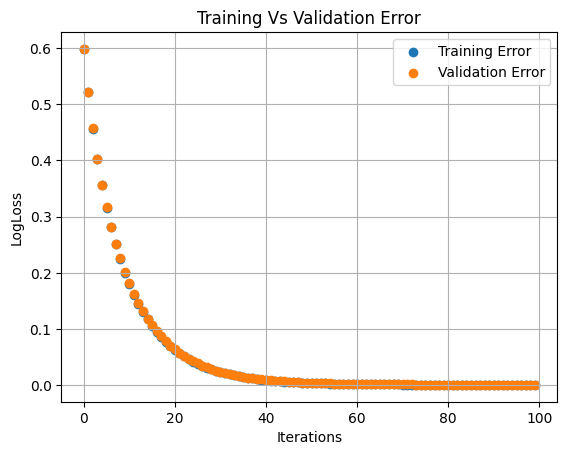

In [20]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['logloss'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['logloss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('LogLoss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

Lets see which features are the most important or have the highest predictive power.

<Figure size 2000x1500 with 0 Axes>

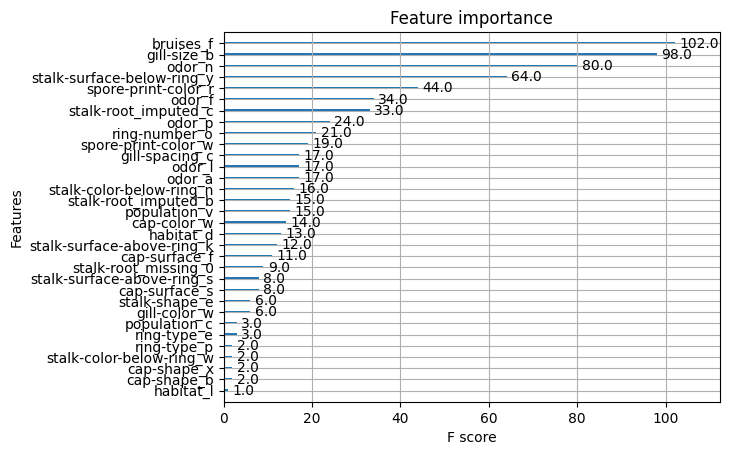

In [21]:
# Assume 'feature_names' is a list of your actual feature names
clf = pipeline.named_steps['classifier']
booster = clf.get_booster()

# Get feature names from the preprocessor
onehot_features = pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(categorical_cols)
# Combine one-hot encoded features with the remaining features
booster.feature_names = list(onehot_features) + [col for col in X_train.columns if col not in categorical_cols]
plt.figure(figsize=(20, 15))
plot_importance(booster)
plt.show()

The model is 100% accurate on the test set as shown below .

In [22]:
# Evaluate
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_encoded, y_pred_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))

Accuracy: 1.0000
ROC AUC: 1.0000
Confusion Matrix:
 [[847   0]
 [  0 778]]


# MODEL-BASED IMPUTATION

Model-based imputation, like using a Random Forest to predict missing values, definitely needs to be done within the training set. Training the imputation model on the entire dataset would leak information into the training process. So, the model should be trained only on the training data and then predict on both training and test sets.

In [24]:
# Split data first (using a fixed random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y['poisonous'], test_size=0.2, random_state=42)

# Only consider rows where 'stalk-root' is not missing for training the imputation model
train_non_missing = X_train[X_train['stalk-root'].notna()]

# Define features (all categorical) except the target for imputation
features = [col for col in X_train.columns if col != 'stalk-root']

# Initialize and fit OneHotEncoder on the non-missing training rows
encoder = OneHotEncoder(handle_unknown='ignore',  sparse_output=False)
encoder.fit(train_non_missing[features])

# Encode the features for the non-missing rows
X_train_encoded = encoder.transform(train_non_missing[features])

# Train the imputation model using the encoded features
imputer_model = RandomForestClassifier(random_state=42)
imputer_model.fit(X_train_encoded, train_non_missing['stalk-root'])

# Function to impute missing values in a dataset
def impute_stalk_root(data):
    missing_mask = data['stalk-root'].isna()
    if missing_mask.any():
        # Encode the features for rows with missing 'stalk-root'
        X_missing_encoded = encoder.transform(data.loc[missing_mask, features])
        # Predict the missing values
        imputed_values = imputer_model.predict(X_missing_encoded)
        data.loc[missing_mask, 'stalk-root'] = imputed_values
    # Add an indicator column for missingness
    data['stalk-root_missing'] = missing_mask.astype(int)
    return data

# Impute missing values in both training and test sets
X_train = impute_stalk_root(X_train)
X_test = impute_stalk_root(X_test)


In [34]:
print(X_train.shape)
print(X_test.shape)
print(X.shape)

(6499, 23)
(1625, 23)
(8124, 22)


In [25]:
# Convert all columns to categorical
X_train = X_train.astype('category')
X_test = X_test.astype('category')
categorical_cols = X_train.columns.tolist()  # Both sets have the same columns


# Encode target (fit only on y_train)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


# Preprocessing: OneHotEncode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"  # Keeps non-categorical columns unchanged
) #, sparse_output=False

preprocessor.fit(X_train)
#categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
X_test_transformed = preprocessor.transform(X_test)




In [26]:
# XGBoost model
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    eval_metric="logloss",
    use_label_encoder=False,  # Disables warning

)#enable_categorical=True



In [27]:
# Create pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

# Enable experimental categorical support in your classifier
pipeline.named_steps['classifier'].set_params(enable_categorical=True)

# Preprocess the evaluation set
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)



In [28]:
# Fit on training data (preprocessor is automatically fitted here)
pipeline.fit(X_train, y_train_encoded,classifier__eval_set=[(X_train_transformed , y_train_encoded), (X_test_transformed, y_test_encoded)]
               ) #
# Predict on test data
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for AUC



[0]	validation_0-logloss:0.59842	validation_1-logloss:0.59833
[1]	validation_0-logloss:0.52133	validation_1-logloss:0.52120
[2]	validation_0-logloss:0.45702	validation_1-logloss:0.45684
[3]	validation_0-logloss:0.40265	validation_1-logloss:0.40242


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:10:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[4]	validation_0-logloss:0.35619	validation_1-logloss:0.35591
[5]	validation_0-logloss:0.31580	validation_1-logloss:0.31559
[6]	validation_0-logloss:0.28076	validation_1-logloss:0.28061
[7]	validation_0-logloss:0.25020	validation_1-logloss:0.25008
[8]	validation_0-logloss:0.22340	validation_1-logloss:0.22333
[9]	validation_0-logloss:0.19983	validation_1-logloss:0.19979
[10]	validation_0-logloss:0.17901	validation_1-logloss:0.17899
[11]	validation_0-logloss:0.16058	validation_1-logloss:0.16058
[12]	validation_0-logloss:0.14421	validation_1-logloss:0.14424
[13]	validation_0-logloss:0.12965	validation_1-logloss:0.12969
[14]	validation_0-logloss:0.11668	validation_1-logloss:0.11672
[15]	validation_0-logloss:0.10509	validation_1-logloss:0.10513
[16]	validation_0-logloss:0.09473	validation_1-logloss:0.09478
[17]	validation_0-logloss:0.08545	validation_1-logloss:0.08550
[18]	validation_0-logloss:0.07714	validation_1-logloss:0.07719
[19]	validation_0-logloss:0.06968	validation_1-logloss:0.0697

In [29]:
# Access the XGBClassifier within the pipeline
eval_result = pipeline.named_steps['classifier'].evals_result()
training_rounds = range(len(eval_result['validation_0']['logloss']))

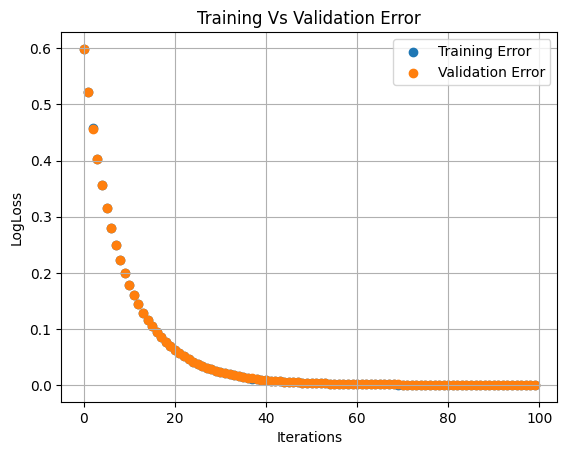

In [30]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['logloss'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['logloss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('LogLoss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

<Figure size 2000x1500 with 0 Axes>

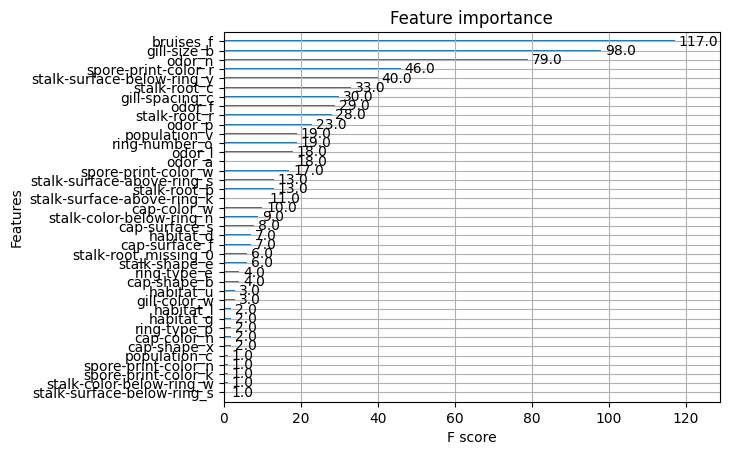

In [31]:
# Assume 'feature_names' is a list of your actual feature names
clf = pipeline.named_steps['classifier']
booster = clf.get_booster()

# Get feature names from the preprocessor
onehot_features = pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(categorical_cols)
# Combine one-hot encoded features with the remaining features
booster.feature_names = list(onehot_features) + [col for col in X_train.columns if col not in categorical_cols]
plt.figure(figsize=(20, 15))
plot_importance(booster)
plt.show()

In [32]:
# Evaluate
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_encoded, y_pred_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))

Accuracy: 1.0000
ROC AUC: 1.0000
Confusion Matrix:
 [[843   0]
 [  0 782]]


# DELETING ALL ROWS WITH MISSING VALUES

In [44]:
data=X.copy()
data['y']=y['poisonous']
data=data[data['stalk-root'].notna()]


In [45]:
y1=data['y']
data.drop('y',axis=1,inplace=True)

In [53]:
# Split data first to avoid leakage
X_train, X_test, y_train, y_test = train_test_split(data, y1, test_size=0.2)


# Convert all columns to categorical
X_train = X_train.astype('category')
X_test = X_test.astype('category')
categorical_cols = X_train.columns.tolist()  # Both sets have the same columns


In [54]:
# Encode target (fit only on y_train)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)


# Preprocessing: OneHotEncode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"  # Keeps non-categorical columns unchanged
) #, sparse_output=False

preprocessor.fit(X_train)
#categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
X_test_transformed = preprocessor.transform(X_test)




In [55]:
# XGBoost model
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    eval_metric="logloss",
    use_label_encoder=False,  # Disables warning

)

In [56]:
# Create pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model)
])

# Enable experimental categorical support in your classifier
pipeline.named_steps['classifier'].set_params(enable_categorical=True)

# Preprocess the evaluation set
X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)



In [57]:
# Fit on training data (preprocessor is automatically fitted here)
pipeline.fit(X_train, y_train_encoded,classifier__eval_set=[(X_train_transformed , y_train_encoded), (X_test_transformed, y_test_encoded)]
               ) #
# Predict on test data
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for AUC


[0]	validation_0-logloss:0.57348	validation_1-logloss:0.56370
[1]	validation_0-logloss:0.49776	validation_1-logloss:0.48966
[2]	validation_0-logloss:0.43524	validation_1-logloss:0.42841
[3]	validation_0-logloss:0.38269	validation_1-logloss:0.37687
[4]	validation_0-logloss:0.33797	validation_1-logloss:0.33295
[5]	validation_0-logloss:0.29954	validation_1-logloss:0.29518
[6]	validation_0-logloss:0.26625	validation_1-logloss:0.26243
[7]	validation_0-logloss:0.23724	validation_1-logloss:0.23389


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:47:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[8]	validation_0-logloss:0.21183	validation_1-logloss:0.20887
[9]	validation_0-logloss:0.18948	validation_1-logloss:0.18686
[10]	validation_0-logloss:0.16976	validation_1-logloss:0.16742
[11]	validation_0-logloss:0.15230	validation_1-logloss:0.15021
[12]	validation_0-logloss:0.13679	validation_1-logloss:0.13492
[13]	validation_0-logloss:0.12300	validation_1-logloss:0.12132
[14]	validation_0-logloss:0.11071	validation_1-logloss:0.10920
[15]	validation_0-logloss:0.09979	validation_1-logloss:0.09839
[16]	validation_0-logloss:0.09002	validation_1-logloss:0.08872
[17]	validation_0-logloss:0.08128	validation_1-logloss:0.08006
[18]	validation_0-logloss:0.07344	validation_1-logloss:0.07229
[19]	validation_0-logloss:0.06636	validation_1-logloss:0.06531
[20]	validation_0-logloss:0.06004	validation_1-logloss:0.05905
[21]	validation_0-logloss:0.05431	validation_1-logloss:0.05341
[22]	validation_0-logloss:0.04922	validation_1-logloss:0.04836
[23]	validation_0-logloss:0.04462	validation_1-logloss:0.

In [58]:
# Access the XGBClassifier within the pipeline
eval_result = pipeline.named_steps['classifier'].evals_result()
training_rounds = range(len(eval_result['validation_0']['logloss']))

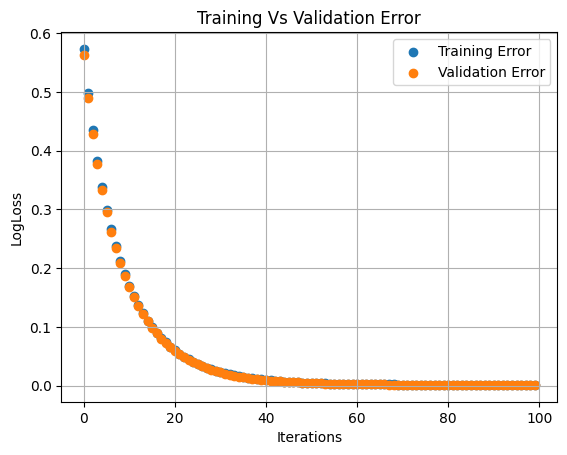

In [59]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['logloss'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['logloss'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('LogLoss')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

<Figure size 2000x1500 with 0 Axes>

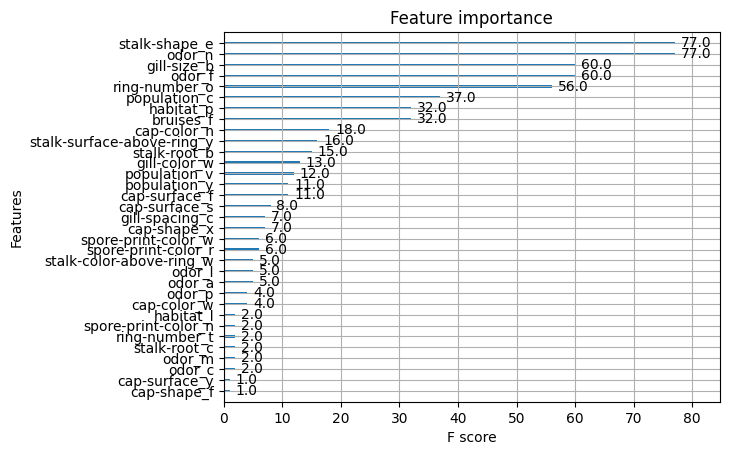

In [60]:
# Assume 'feature_names' is a list of your actual feature names
clf = pipeline.named_steps['classifier']
booster = clf.get_booster()

# Get feature names from the preprocessor
onehot_features = pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(categorical_cols)
# Combine one-hot encoded features with the remaining features
booster.feature_names = list(onehot_features) + [col for col in X_train.columns if col not in categorical_cols]
plt.figure(figsize=(20, 15))
plot_importance(booster)
plt.show()

In [61]:
# Evaluate
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_encoded, y_pred_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))

Accuracy: 1.0000
ROC AUC: 1.0000
Confusion Matrix:
 [[722   0]
 [  0 407]]


#A MODEL THAT INHERENTLY HANDLES MISSING DATA:LightGBM

LightGBM handles categorical features and missingness natively.

In [72]:
# Fill missing values (if any) with a placeholder before converting to categorical.
X = X.fillna('missing')

# Split data (assuming y is a DataFrame with a column "poisonous")
X_train, X_test, y_train, y_test = train_test_split(
    X, y['poisonous'], test_size=0.2, random_state=42
)


In [73]:
# Convert all columns to categorical
X_train = X_train.astype('category')
X_test = X_test.astype('category')
categorical_cols = X_train.columns.tolist()

# Encode target (fit only on y_train)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Preprocessing: OneHotEncode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="passthrough"  # Keeps non-categorical columns unchanged
)


In [74]:
model5 = lgb.LGBMClassifier(enable_categorical=True)


In [75]:
# Create pipeline with preprocessor and classifier
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", model5)
])

# Pre-fit the preprocessor for evaluation (we must transform eval data manually)
X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)


In [81]:
# Fit the pipeline.
# Note: The eval_set is passed directly to the classifier, so we supply preprocessed data.
pipeline.fit(
    X_train,
    y_train_encoded)#classifier__eval_set=[(X_train_transformed, y_train_encoded), (X_test_transformed, y_test_encoded)]

# Predict on test data using the pipeline (which will transform the data before predicting)
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probabilities for AUC


[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Warning] Unknown parameter: enable_categorical
[LightGBM] [Info] Number of positive: 3134, number of negative: 3365
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 6499, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.482228 -> initscore=-0.071118
[LightGBM] [Info] Start training from score -0.071118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [82]:
# Evaluate using the encoded target values
print(f"Accuracy: {accuracy_score(y_test_encoded, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test_encoded, y_pred_proba):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_test_encoded, y_pred))

Accuracy: 1.0000
ROC AUC: 1.0000
Confusion Matrix:
 [[843   0]
 [  0 782]]
